In [1]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
meas_first_row = session.query(Measurement).first()
stat_first_row = session.query(Station).first()
meas_first_row.__dict__
#stat_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1372fd660>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()

#Save it in a variable converted to datetime using the datetime module
end_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database, calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp).filter(func.strftime(Measurement.date) >= start_date).all()

In [178]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_12_months, columns = ['Date', 'Precipitation'])

In [179]:
# Fill null values in Precipitation column with 0
df['Precipitation'] = df['Precipitation'].fillna(0)

In [180]:
#Check for null values again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           2230 non-null   object 
 1   Precipitation  2230 non-null   float64
dtypes: float64(1), object(1)
memory usage: 35.0+ KB


In [181]:
#Sort the dataframe by date and set index as Date
df = df.sort_values(by = 'Date').set_index('Date')
df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


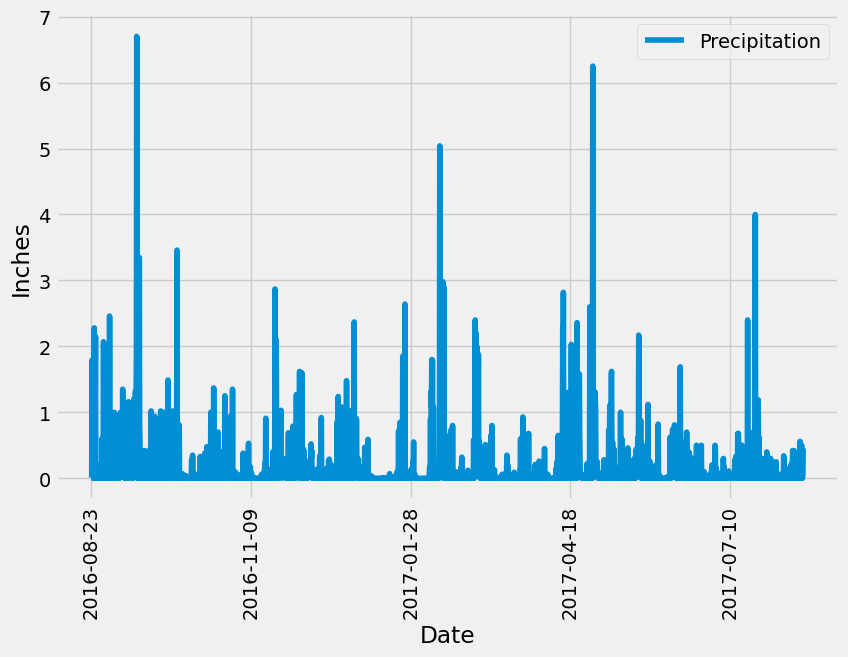

In [182]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize'] = (9, 6) 
ax = df.plot(rot=90, label = 'precipitation')
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
#ax.set_facecolor('lightgrey')
ax.legend(loc = 'best')
plt.show()

In [183]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [123]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Measurement.station).distinct().count()
total_stations

9

In [140]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [143]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# most active station id: USC00519281
active_station_temps = session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()
active_station_temps

[(85.0, 54.0, 71.66378066378067)]

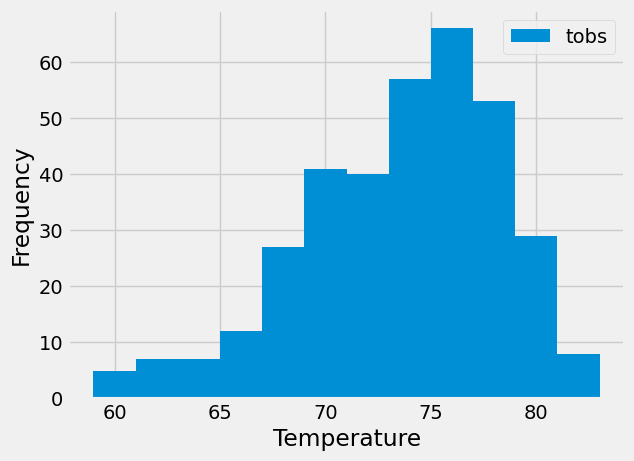

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281')\
    .filter(func.strftime(Measurement.date) >= start_date).group_by(Measurement.date).all()

#Save query results in dataframe
most_active_df = pd.DataFrame(most_active_station)

#Plot histogram
plt.hist(most_active_df.tobs, bins = 12, label = 'tobs')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend(loc = 'best')
plt.show()

# Close Session

In [20]:
# Close Session
session.close()